# XAFS Data Processing 1

Here we'll use Larch to replicate the examples from [Bruce Ravell's tutorial](https://www.diamond.ac.uk/Instruments/Spectroscopy/Techniques/XAS.html) at diamond 
for XAFS data processing:

  1. read data from an ascii file
  2. do normalisation
  3. do XAFS background subtraction with autobk()
  4. do XAFS Fourier transform with xfft()
  
For more details, see https://xraypy.github.io/xraylarch/xafs/

We'll start with reading and a raw data file:

## Data Readers
The first example requires loading a dataset and doing some basic analysis.
The available readers are read_ascii(), read_xdi(), and read_gsexdi() for text column files and read_athena() and extract_athenagroup(), for Athena Project files.

In [1]:
from larch.io import read_ascii
# https://vimeo.com/340207346 07:01
fe_xafs = read_ascii('XAFSExamples/Fe_standards/Fe_lepidocrocite.000')
# using vars(fe_data) we see that the object has the following properties: 
# path, filename, header, data, attrs, energy, i0, it, ir, inttime, and labels
# vars(fe_xafs)

In [2]:
# the following prints show the contents of each
print("path:\t\t", fe_xafs.path)
print("filename:\t", fe_xafs.filename)
print(fe_xafs.header)
print(fe_xafs.data)
print(fe_xafs.attrs)
print(fe_xafs.energy)
print(fe_xafs.i0)
print(fe_xafs.it)
print(fe_xafs.inttime)
print(fe_xafs.array_labels)

path:		 XAFSExamples/Fe_standards/Fe_lepidocrocite.000
filename:	 Fe_lepidocrocite.000
['XDAC V1.4 Datafile V1', '"Fe_lepidocrocite.000" created on 11/3/2011 at 1:10:04 PM on X-23A2', 'Diffraction element= Si (311).  Ring energy= 2.80 GeV', 'E0= 7112.00', 'NUM_REGIONS= 4', 'SRB= -200 -20 30 60 15k', 'SRSS= 10 0.25 0.05k 0.05k', 'SPP= 0.5 0.5 0.5 0.125k', 'Settling time= 0.10', 'Offsets= 0.00 37.25 86.25 0.00', 'Gains= 8.00 8.00 9.00 1.00', 'gamma-FeOOH on tape', '--------------------------------------------------------------------------------', 'Energy            I0            It            Ir       IntTime']
[[6.91200137e+03 6.92199811e+03 6.93199952e+03 ... 7.95994966e+03
  7.96564138e+03 7.97135723e+03]
 [5.00400000e+03 5.00600000e+03 5.03100000e+03 ... 1.85870000e+04
  1.86510000e+04 1.87000000e+04]
 [7.26375000e+02 7.34375000e+02 7.45375000e+02 ... 4.70652880e+03
  4.74430530e+03 4.77608180e+03]
 [1.40187500e+03 1.41987500e+03 1.44687500e+03 ... 6.26514380e+03
  6.32662630e+03 6.3

## Calculate and plot $\mu$
Knowing the elements of the input data set it is possible to start manipulating and visualising the XAFS data. 

The following examples show how to calculate $\mu$ and plot it agains the energy.

So far I have not found the larch function for calculating $\mu$, so instead I created a function that calculates $\mu$ and adds it to the group.
Similarly, groups cannot be copied so the function below creates a new group and returns it, so creates a copy

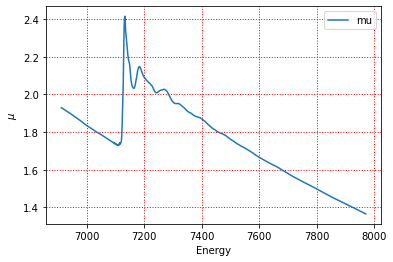

In [3]:
# https://vimeo.com/340207346 15:06
from numpy import log
from larch.utils import group2dict, dict2group

# Calculate mu 
def get_mu(xafs_group):
    # calculate mu
    mu_e = log(abs(xafs_group.i0/xafs_group.it))
    # get a dictionary from te group
    xafs_dict = group2dict(xafs_group)
    # add mu to the dictionary
    xafs_dict['mu'] = mu_e
    xafs_group = dict2group(xafs_dict)
    return xafs_group

# create a copy of the group
def copy_group(xafs_group):
    # get a dictionary from te group
    xafs_dict = group2dict(xafs_group)
    #xafs_dict['filename']=xafs_dict['filename']+"_copy"
    new_group = dict2group(xafs_dict)
    new_group.filename = new_group.filename+"_copy" 
    return new_group

fe_xafs = get_mu(fe_xafs)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(fe_xafs.energy, fe_xafs.mu, label='mu')
plt.xlabel('Energy')
plt.ylabel('$\mu$')
plt.legend() # include the leyend in the plot
plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid

After loading athena presents the oscilatory spectrum, the r-space and the q-space. Athena uses several default parameter values. Using those same default values it is possible to try and reproduce the initial results for loading a file, starting with normalisation. 

The default values on athena are shown in the table below.

|Area | Varialbe      | Value    |
|:-----:|:------------- |:--------:|
| Current Group| File | XAFSExamples/Fe_standards/Fe_lepidocrocite.000|
|| Element       |   26 Iron |
|| Edge |   K |
|Background removal and normalisation| E0|7128.74769|
||rbkg|1.0|
||flaten normalised data|true|
||k-weight| 2|
||normalization order|3|
||pre-edge range| \[ -150.00, -30.00\]|
| |Edge step| 0.461424|
| |fix|false
| |normalization range| \[ 150.00, 742.610\]|
| |spline range in k| \[ 0, 14.871\]|
| |spline range in e| \[ 0, 842.5651\]|
| |spline clamps low| none|
| |spline clamps low| strong|
| |standard|none|
|Forward fourier transform|k-range| \[ 3.000, 12.871\]|
| |dk|1|
| |window|Hanning|
| |arbitrary k-weight|0.5|
| |phase correction|false|
|Backward fourier transform|R-range| \[ 1, 3\]|
| |dR|0.0|
| |window|Hanning|
|Plotting|plot multiplier|1|
| |y-axis offset|0|
| |e-min|-200|
| |e-max|800|


## Normalisation 
The pre_edge function performs Pre-edge subtraction and normalization. The function performs a number of steps:
 1. determine E<sub>0</sub> (if not supplied) from max of deriv(mu)
 2. fit a line of polynomial to the region below the edge
 3. fit a polynomial to the region above the edge
 4. extrapolate the two curves to <it>E</it><sub>0</sub> to determine the edge jump
The group passed as an argument will contain the results of the arguments which are listed in the following table.

|attribute|meaning|
|:----|:----|
|e0|energy origin|
|edge_step|edge step|
|norm|normalized mu(E) (array)|
|flat|flattened, normalized mu(E) (array)|
|pre_edge|pre-edge curve (array)|
|post_edge|post-edge, normalization curve (array)|
|pre_slope|slope of pre-edge line|
|pre_offset|offset of pre-edge line|
|nvict|value of nvict used|
|nnorm|value of nnorm used|
|norm_c0|constant of normalization polynomial|
|norm_c1|linear coefficient of normalization polynomial|
|norm_c2|quadratic coefficient of normalization polynomial|
|norm_c*|higher power coefficients of normalization polynomial|

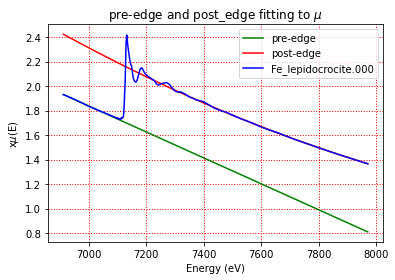

In [4]:
# https://vimeo.com/340207346 25:00
from larch.xafs import pre_edge
#calculate pre-edge and post edge and add them to group
pre_edge(fe_xafs, group=fe_xafs)

plt.plot(fe_xafs.energy, fe_xafs.pre_edge, 'g', label='pre-edge') # plot pre-edge in green
plt.plot(fe_xafs.energy, fe_xafs.post_edge, 'r', label='post-edge')# plot post-edge in green
plt.plot(fe_xafs.energy, fe_xafs.mu, 'b', label=fe_xafs.filename) # plot mu in blue
plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
plt.xlabel('Energy (eV)') # label y graph
plt.ylabel('x$\mu$(E)') # label y axis
plt.title("pre-edge and post_edge fitting to $\mu$")
plt.legend() # show legend

Normalisation is intednded to take out the effect of thickness and/or amplifier gain which might affect the calculation of $\mu$.

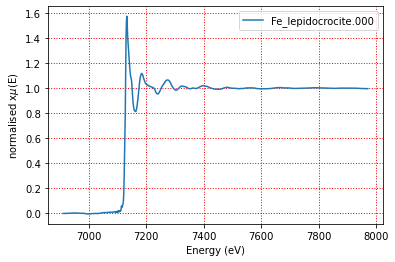

In [5]:
# https://vimeo.com/340207346 27:00
plt.plot(fe_xafs.energy, fe_xafs.flat, label=fe_xafs.filename) # plot flattened and normalised energy
plt.grid(color='r', linestyle=':', linewidth=1) #show and format grid
plt.xlabel('Energy (eV)') # label y graph
plt.ylabel(r'normalised x$\mu$(E)') # label y axis
plt.legend() # show legend

In [6]:
# these two lines help when formating subscripts and
# supperscripts for printing
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

print( 'Element Symbol', "\t", fe_xafs.atsym)
print ('Edge',"\t\t", fe_xafs.edge)
print ('E0'.translate(SUB),"\t\t", fe_xafs.e0)
print ('Edge Step',"\t", fe_xafs.edge_step)

Element Symbol 	 Fe
Edge 		 K
E₀ 		 7128.4977
Edge Step 	 0.45692757080772495


## Background and Chi
The function autobk can be used to determine the post-edge background function, $\mu$<sub>0</sub>(E), and corresponding $\chi$<sup>(k)</sup>
(https://xraypy.github.io/xraylarch/xafs/autobk.html)

Note that we pass in the *Group*  (fe_xafs) as the  argument.  The `autobk()` function will add several attributes to this Group -- it will be the container for this dataset.

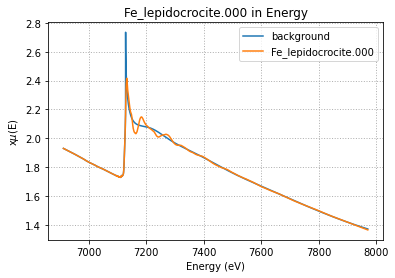

In [7]:
from larch.xafs import autobk
autobk(fe_xafs, rbkg=1.0) # using defaults so no additional parameters are passed
plt.plot(fe_xafs.energy, fe_xafs.bkg, label='background')
plt.plot(fe_xafs.energy, fe_xafs.mu, label=fe_xafs.filename) # plot mu 
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.xlabel(r'Energy (eV)')
plt.ylabel(r'x$\mu$(E)')
plt.title(fe_xafs.filename+" in Energy")
plt.legend()

We can avoid having to type out the full markup for the labels in the plots by importing them from larch as follows:

In [8]:
# import plot labels to avoid having to type the markup
from larch.wxlib import plotlabels as plab
# the following prints the list of titles for the plots
print(dir(plab))

['chie', 'chikw', 'chir', 'chirim', 'chirlab', 'chirmag', 'chirpha', 'chirre', 'deconv', 'dmude', 'dnormde', 'e0color', 'energy', 'flat', 'k', 'mu', 'norm', 'r']


The plot $k$-weighted $\chi(k)$ is equivalent to the plot in the k space from Athena

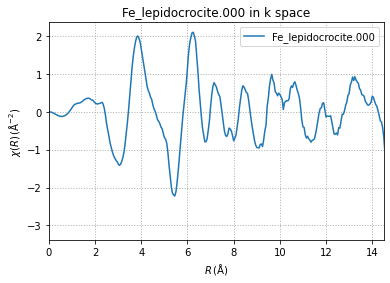

In [9]:
# https://vimeo.com/340207346 36:14
plt.plot(fe_xafs.k, fe_xafs.chi*fe_xafs.k**2, label=fe_xafs.filename)
plt.xlabel(plab.r)
plt.ylabel(plab.chir.format(2))
plt.title(fe_xafs.filename+" in k space")
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.xlim(0,14.5)
plt.legend()

## Fourier transform 
Now we will do the Fourier transform from 𝜒(𝑘) to 𝜒(𝑅), using the xftf() (XAFS Fourier Transform Forward) function. We'll do the Fourier transform on 𝑘2 weighted 𝜒(𝑘) with a Hanning Window. 

Note that the values passed to xftf are the same as the defaults for Athena.

In [10]:
from larch.xafs import xftf
xftf(fe_xafs, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')

(0.0, 6.0)

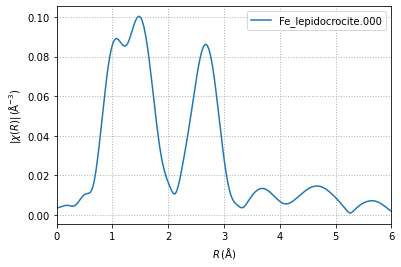

In [11]:
# https://vimeo.com/340207346 40:00
# plot magnitude in r-space
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename)
plt.xlabel(plab.r)
plt.ylabel(plab.chirmag.format(3))
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.legend()
plt.xlim(0,6)

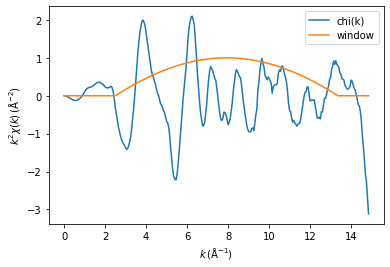

In [12]:
# https://vimeo.com/340207346 41:00
plt.plot(fe_xafs.k, fe_xafs.chi*fe_xafs.k**2, label='chi(k)')
plt.plot(fe_xafs.k, fe_xafs.kwin, label='window')
plt.xlabel(plab.k)
plt.ylabel(plab.chikw.format(2))
plt.legend()

and we can show that data as 𝜒(𝑅)

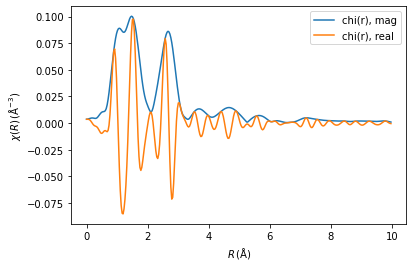

In [13]:
plt.plot(fe_xafs.r, fe_xafs.chir_mag, label='chi(r), mag')
plt.plot(fe_xafs.r, fe_xafs.chir_re, label='chi(r), real')
plt.xlabel(plab.r)
plt.ylabel(plab.chir.format(3))
plt.legend()

## Changing parameters
Make a copy of the data to show the difference when the default parameters are changed. The copy contains all the values calculated up to this point.

In [14]:
# https://vimeo.com/340207346 44:30
fe_xafs_copy = copy_group(fe_xafs)

Now we redo the calculations modifying the default value for background

In [15]:
autobk(fe_xafs_copy, rbkg=0.2)
xftf(fe_xafs_copy, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')

Now we plot both the copy and the original side by side to see the effects of the parameter change.

The copy uses does the background removal with a smaller Rbgk, and thus shows a peak in the 

(0.0, 6.0)

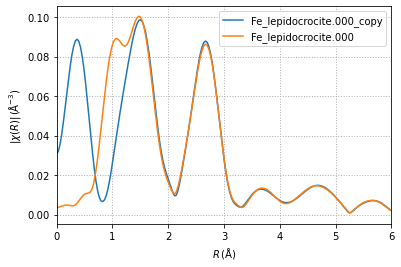

In [16]:
# https://vimeo.com/340207346 47:00
# plot magnitude in r-space
plt.plot(fe_xafs_copy.r, fe_xafs_copy.chir_mag,label=fe_xafs_copy.filename)
plt.plot(fe_xafs.r, fe_xafs.chir_mag,label=fe_xafs.filename)
plt.xlabel(plab.r)
plt.ylabel(plab.chirmag.format(3))
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.legend()
plt.xlim(0,6)

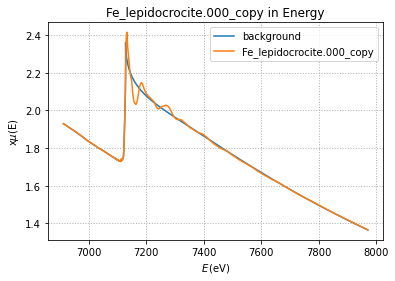

In [17]:
plt.plot(fe_xafs_copy.energy, fe_xafs_copy.bkg, label='background')
plt.plot(fe_xafs_copy.energy, fe_xafs_copy.mu, label=fe_xafs_copy.filename) # plot mu 
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.xlabel(plab.energy)
plt.ylabel(r'x$\mu$(E)')
plt.title(fe_xafs_copy.filename+" in Energy")
plt.legend()

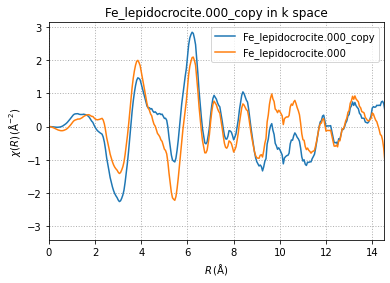

In [18]:
# https://vimeo.com/340207346 49:00
plt.plot(fe_xafs_copy.k, fe_xafs_copy.chi*fe_xafs_copy.k**2, label=fe_xafs_copy.filename)
plt.plot(fe_xafs.k, fe_xafs.chi*fe_xafs.k**2, label=fe_xafs.filename)
plt.xlabel(plab.r)
plt.ylabel(plab.chir.format(2))
plt.title(fe_xafs_copy.filename+" in k space")
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.xlim(0,14.5)
plt.legend()

(0.0, 6.0)

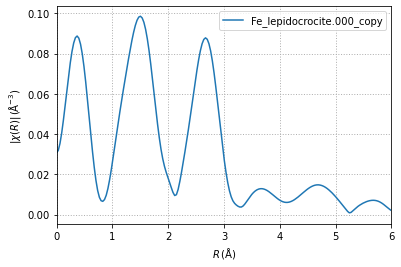

In [19]:
# https://vimeo.com/340207346 50:00
# plot magnitude in r-space
plt.plot(fe_xafs_copy.r, fe_xafs_copy.chir_mag,label=fe_xafs_copy.filename)
plt.xlabel(plab.r)
plt.ylabel(plab.chirmag.format(3))
plt.grid(linestyle=':', linewidth=1) #show and format grid
plt.legend()
plt.xlim(0,6)

In [20]:
This is the end of [session 2](https://vimeo.com/340207346). 

SyntaxError: invalid syntax (<ipython-input-20-556658dba778>, line 1)